In [1]:
# encoding=utf8  
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
import scipy.interpolate
import scipy.optimize
import sys
import math
import numpy.ma as ma
#from ipywidgets import interact

def CW(T, C, th): #curie weiss fit
	return C/(T-th)
def CW_lam(T, C, th,lam): #curie weiss fit + constant offset
	return C/(T-th)+lam
def CW_lam_par(T, C, th,lam,C2): #curie weiss fit + constant offset + paramagnetism
	return C/(T-th)+lam+C2/T

In [2]:
def coth(x):
  return 1/np.tanh(x)
def raw_datafile_2_chi(data_file,molar_mass,mass,dia):
    head_len = 31 # lines in the header
    #data_file = "CsMnNCS3_ZFC_field_zocefa.rso.dat" # name of the data file
    data = np.genfromtxt(data_file,skip_header=head_len,delimiter=',') 
    data = data[np.argsort(data[:, 3])] # sort all data by temperature
    time = data[:,0] #in s
    fields = data[:,2] # in Oe
    T = data[:,3] # in K
    M = data[:,4] # in emu
    M_err = data[:,5] # in emu

    #molar_mass = 362.09#g mol-1
    #mass = 9.6 *1e-3 #mg
    #dia = 100*1e-6 # 1e-6 emu mol-1 #need to calculate
    field = fields[0] #Oersted
    
    chi = M/field * molar_mass / mass + dia
    chi_err = M_err/field * molar_mass / mass
    return T,chi,chi_err

def raw_datafile_2_chi_ZFC(data_file,molar_mass,mass,dia):
    head_len = 31 # lines in the header
    #data_file = "CsMnNCS3_ZFC_field_zocefa.rso.dat" # name of the data file
    data_ZFC = np.genfromtxt(data_file,skip_header=head_len,delimiter=',') 
    data_ZFC = data_ZFC[np.argsort(data_ZFC[:, 3])] # sort data by temperature
    time = data_ZFC[:,0] #in s
    fields_ZFC = data_ZFC[:,2] # in Oe
    T_ZFC = data_ZFC[:,3] # in K
    M_ZFC = data_ZFC[:,4] # in emu
    M_err_ZFC = data_ZFC[:,5] # in emu

    #molar_mass = 362.09#g mol-1
    #mass = 9.6 *1e-3 #mg
    #dia = 100*1e-6 # 1e-6 emu mol-1 #need to calculate
    field_ZFC = fields_ZFC[0] #Oersted
    
    chi_ZFC = M_ZFC/field_ZFC * molar_mass / mass + dia
    chi_err_ZFC = M_err_ZFC/field_ZFC * molar_mass / mass
    return T_ZFC,chi_ZFC,chi_err_ZFC
    
def raw_datafile_2_chi_FC(data_file,molar_mass,mass,dia):
    head_len = 31 # lines in the header
    #data_file = "CsMnNCS3_ZFC_field_zocefa.rso.dat" # name of the data file
    data_FC = np.genfromtxt(data_file,skip_header=head_len,delimiter=',') 
    data_FC = data_FC[np.argsort(data_FC[:, 3])] # sort data by temperature
    time_FC = data_FC[:,0] #in s
    fields_FC = data_FC[:,2] # in Oe
    T_FC = data_FC[:,3] # in K
    M_FC = data_FC[:,4] # in emu
    M_err_FC = data_FC[:,5] # in emu

    #molar_mass = 362.09#g mol-1
    #mass = 9.6 *1e-3 #mg
    #dia = 100*1e-6 # 1e-6 emu mol-1 #need to calculate
    field_FC = fields_FC[0] #Oersted

    chi_FC = M_FC/field_FC * molar_mass / mass + dia
    chi_err_FC = M_err_FC/field_FC * molar_mass / mass
    return T_FC,chi_FC,chi_err_FC

def raw_datafile_2_AC(data_file,molar_mass,mass):
    import numpy as np
    head_len = 28
    data = np.genfromtxt(data_file,skip_header=head_len,delimiter=',') 
    data = data[np.argsort(data[:, 3],kind='stable')] #sort by T
    data = data[np.argsort(data[:, 14],kind='stable')] #sort by freq

    T = data[:,3]
    T = T.round(decimals=1) # to make sure the Temperatures are identical at the same point
    amp = data[:,8] #|m| (emu)
    s_amp = data[:,9]
    phase = data[:,10] #phase of m (deg)
    s_phase = data[:,11]
    reg_fit = data[:,12] #regression fit
    field = 1000 #Oe
    driver = data[0,13] #driver amplitude (Oe)
    freq = data[:,14] #Hz
    freq_list = np.unique(freq)
    T_list = np.unique(T)
    m = data[:,4]/(driver) * molar_mass / mass #m' in emu Oe-1 mol-1
    s_m = data[:,5]/driver * molar_mass / mass #sigma m'in emu Oe-1 mol-1
    md = data[:,6]/driver * molar_mass / mass # m''in emu Oe-1 mol-1
    s_md = data[:,7]/driver * molar_mass / mass #sigma m''in emu Oe-1 mol-1
    return freq,freq_list,T,T_list,m,s_m,md,s_md

def raw_datafile_2_MH(data_file,molar_mass,mass,dia):
    head_len=31
    data = np.genfromtxt(data_file,skip_header=head_len,delimiter=',')

    Oe = 1e4 #unit conversion
    muB = 9.27401e-21 * 6.022140e23

    time = data[:,0] #in s
    field = data[:,2] # in Oe
    T = data[0,3] # in K
    M = data[:,4] # in emu
    M_err = data[:,5] # in emu
    
    H =  field / Oe   
    conv =  molar_mass / mass #* 1e-3 / muB
    M = M*conv
    BMM = M / muB
    return H,M,BMM



def datafile_2_MH(data_file):
    head_len=4
    data = np.genfromtxt(data_file,skip_header=head_len)
    Oe = 1e4
    H =  np.array(data[:,0]) / Oe   

    fh = open(data_file,'r')
    param = np.zeros(head_len)
    for i,line in enumerate(fh):
    	if i is head_len: break
    	param[i]= line
    fh.close()

    molar_mass = param [0] #g mol-1
    mass = param [1]*1e-3 #mg
    dia = param [2]*1e-6 # 1e-6 emu mol-1
    T =  param[3] #K
    muB = 9.27401e-21 * 6.022140e23

    conv =  molar_mass / mass #* 1e-3 / muB
    M = data[:,1]*conv
    BMM = M / muB
    return H,M,BMM

def B_s(S,y): #Brillouin function, diff. to Johnston
    return (2.0*S+1.0)/(2.0*S)*coth((2.0*S+1.0)/(2.0*S)*y)-coth(y/(2.0*S))/(2.0*S)
#y = g_J * muB * J * B  /kT

def lang(y): #Langevin
    return coth(y)-1/y


def mu_lin(T,S,lam,g,y):
    k_b = 1.3806488e-23
    mu_b = 9.27400e-24 #SI value
    return k_b*T*y/(g*mu_b *S*lam)

def mu0_det(y,T,S,lam,g,Ms):    
    k_b = 1.3806488e-23
    mu_b = 9.27400e-24 #SI value
    return (B_s(S,y)*Ms-mu_lin(T,S,lam,g,y))**2

def mu0(S,ts):
    out = np.zeros_like(ts)
    i=0
    for t in ts:
        out[i] = scipy.optimize.minimize_scalar(mu0_det,args=(S,t), tol=None, options=None).get('x') #    method='bounded',bounds=(0,1)
        i=i+1
    return out

def brillouin_T(Ts,S,lam,g,Ms): #brillouin function of moment as a function of T
    #S = spin
    #lam = molecular field
    #g = g-value
    #Ms = saturation moment
    k_b = 1.3806488e-23
    mu_b = 9.27400e-24 #SI value
    y = np.zeros_like(Ts)
    M_out = np.zeros_like(Ts)
    test = np.zeros_like(Ts)  
    test2 = np.zeros_like(Ts)      
    i=0
    for t in Ts:
        fit = scipy.optimize.minimize(mu0_det,args=(t,S,lam,g,Ms), #method='bounded',bounds=(0,1),
     tol=None, x0=(1000))
        y[i] =fit.get('x') #determine y
        M_out[i] = B_s(S,y[i])*Ms
       # test[i] = (k_b*t*y[i])/(g*mu_b*S*lam)
       # test2[i]  =mu0_det(t,S,lam,g,Ms,y[i])#k_b * t * y[i]/(g*mu_b*S*lam)
        i=i+1       
    return M_out
#def brillouin_T(Ts,S,lam,g,Ms):

def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

In [3]:
#Diamagnetic Contributions

#Sample
molar_mass = 202.99#g mol-1 #####
mass = 26.6 *1e-3 #mg ####
sample_dia = 101.2*1e-6 # 1e-6 emu mol-1 

#Eicosane
eicosane_molar_mass = 282.55 #g mol-1 ####
eicosane_mass = 44.5 *1e-3 #mg ####
eicosane_molar_dia = 243.06*1e-6 # 1e-6 emu mol-1 

#Diamagnetic contribution of eicosane per mole of CrCl2pym
eicosane_dia = (((eicosane_mass)/eicosane_molar_mass)*eicosane_molar_dia)/(mass/molar_mass)

print(eicosane_dia*1e6)

dia = sample_dia + eicosane_dia # 1e-6 emu mol-1 

292.12666442694945


<IPython.core.display.Javascript object>


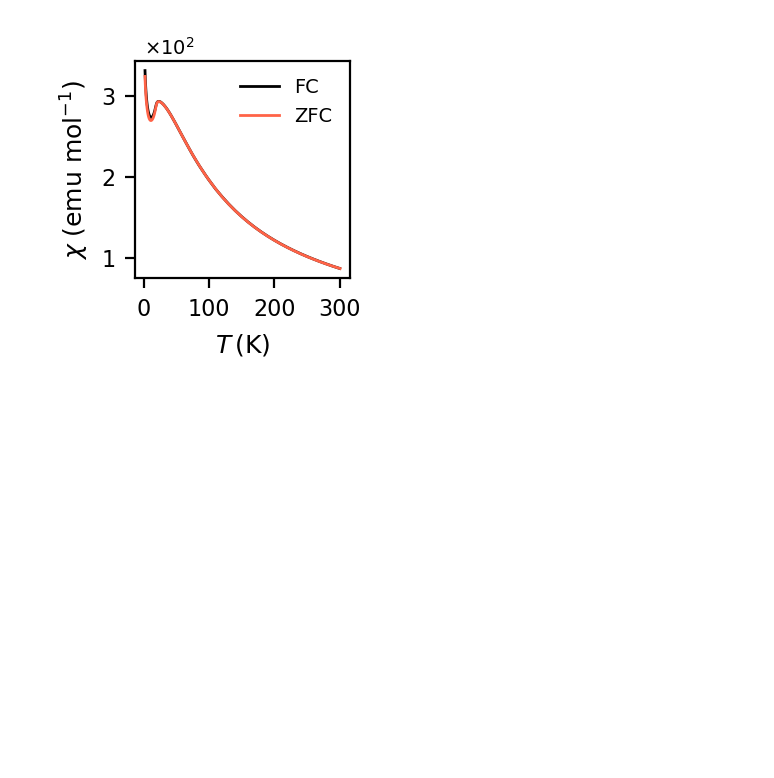

In [4]:
fig = plt.figure(1)#, figsize=(2, 2))
ax1 = plt.subplot()

set_size(1.5,1.5, ax=ax1)

T_FC,chi_FC,chi_err_FC=raw_datafile_2_chi_FC("MPMS_CrCl2pym_FC.rso.dat",molar_mass,mass,dia)
plt.plot(T_FC,chi_FC*100,label='FC', color="black", linewidth=1,)

T_ZFC,chi_ZFC,chi_err_ZFC=raw_datafile_2_chi("MPMS_CrCl2pym_ZFC.rso.dat",molar_mass,mass,dia)
plt.plot(T_ZFC,chi_ZFC*100,label='ZFC', color="tomato", linewidth=1,)

plt.legend(shadow=False, fontsize=7,loc=1,frameon=False)#,bbox_to_anchor=(1.1, 1.05))
plt.xlabel('$T\\,$(K)',fontsize=9)
plt.ylabel('$\\chi$ (emu mol$^{-1}$)',fontsize=9)
ax1.tick_params(axis='both', labelsize=8)
ax1.set_xticks(ticks=[0,100,200,300])
#ax1.set_yticks(ticks=[0.4,0.8,1.2])
ax1.text(0, 3.5, '$\\times 10^2$',fontsize=7)
plt.tight_layout()
plt.rcParams['pdf.fonttype'] = 3
#plt.savefig('Cr(pym)Cl$_2$_chi_ZFC_FC.pdf', bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


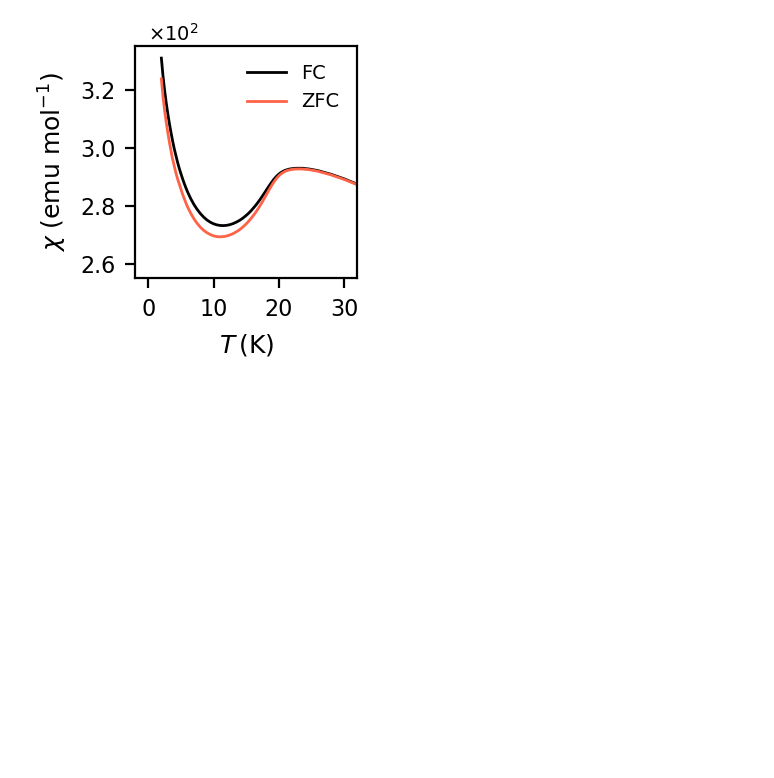

In [5]:
fig = plt.figure(111)#, figsize=(1.97, 1.94))
ax1 = plt.subplot()

set_size(1.5,1.5, ax=ax1)

T_FC,chi_FC,chi_err_FC=raw_datafile_2_chi_FC("MPMS_CrCl2pym_FC.rso.dat",molar_mass,mass,dia)
plt.plot(T_FC,chi_FC*100,label='FC', color="black", linewidth=1,)

T_ZFC,chi_ZFC,chi_err_ZFC=raw_datafile_2_chi("MPMS_CrCl2pym_ZFC.rso.dat",molar_mass,mass,dia)
plt.plot(T_ZFC,chi_ZFC*100,label='ZFC', color="tomato", linewidth=1,)

plt.legend(shadow=False, fontsize=7,loc=1,frameon=False)#,bbox_to_anchor=(1.1, 1.05))
plt.xlabel('$T\\,$(K)',fontsize=9)
plt.ylabel('$\\chi$ (emu mol$^{-1}$)',fontsize=9)
ax1.tick_params(axis='both', labelsize=8)
ax1.set_xticks(ticks=[0,10,20,30])
#ax1.set_yticks(ticks=[0.4,0.8,1.2])
ax1.text(0, 3.37, '$\\times 10^2$',fontsize=7)
plt.tight_layout()
plt.rcParams['pdf.fonttype'] = 3
plt.xlim(-2,32)
#plt.ylim(0.006,0.036)
plt.ylim(2.55,3.35)
#plt.savefig('Cr(pym)Cl$_2$_chi_ZFC_FC_0-50.pdf', bbox_inches='tight', transparent=True)
plt.show()

<IPython.core.display.Javascript object>


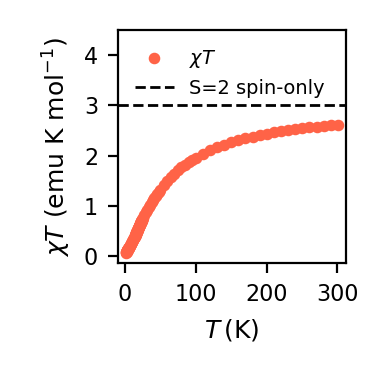

In [6]:
fig = plt.figure(3, figsize=(1.88, 1.91))
cmap = plt.get_cmap('Set1')
ax2 = plt.subplot()

T_ZFC,chi_ZFC,chi_err_ZFC=raw_datafile_2_chi_ZFC("MPMS_CrCl2pym_ZFC.rso.dat",molar_mass,mass,dia)
plt.scatter(T_ZFC,chi_ZFC*T_ZFC, marker="o", c="tomato", s=10,label='$\\chi T$')

plt.xlim(-10,312)
plt.ylim(-0.15,4.5)
plt.hlines(3,-10,315, label="S=2 spin-only", color='k', lw=1, ls='dashed')

plt.legend(shadow=False, fontsize=7,loc=2,frameon=False)
plt.xlabel('$T\\,$(K)',fontsize=9)
plt.ylabel('$\\chi T$ (emu K mol$^{-1}$)',fontsize=9)
plt.tight_layout()
plt.rcParams['pdf.fonttype'] = 3
ax2.set_xticks(ticks=[0,100,200,300])
ax2.tick_params(axis='both', labelsize=8)
#plt.savefig('Cr(pym)Cl$_2$_chiT.pdf', bbox_inches='tight', transparent=True)
plt.show()

BM 4.968530884707128 ( 0.22122991942176165 )
Weiss T -54.10803548223565 ( 0.5276472847079678 )


<IPython.core.display.Javascript object>


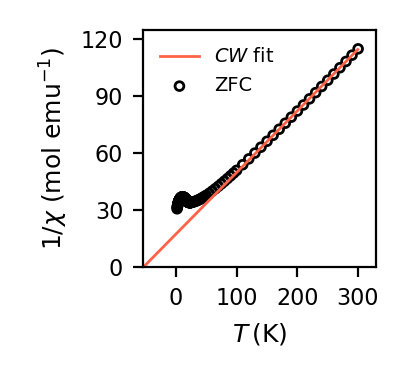

In [7]:
#Curie Weiss fitting 
T,chi,chi_err=raw_datafile_2_chi("MPMS_CrCl2pym_ZFC.rso.dat",molar_mass,mass,dia)
start = np.argmax(T>150) #this number here determines where the CW fit starts
p0 = (3,-60)

popt, pcov = scipy.optimize.curve_fit(CW, T[start:], chi[start:],sigma=chi_err[start:],p0=p0)
perr = np.sqrt(np.diag(pcov))
print ('BM', (popt[0]*8)**0.5,'(',(8*pcov[0,0]**0.5)**0.5,')')
print ('Weiss T', (popt[1]),'(',pcov[1,1]**0.5,')')
#1/chi plot
fig = plt.figure(4, figsize=(2.03,1.89))

ax3 = plt.subplot()
T_range = np.arange(0.01,300,0.01)

m, c = np.polyfit(T, 1/CW(T,*popt), 1)

x=np.arange(-60,305,5)

plt.plot(x, m*x + c, color='tomato', label='$CW$ fit', linewidth=1)


plt.scatter(T,1.0/(chi),label='ZFC', marker="o", edgecolor="black", facecolor='none', s=10)

plt.xlim(-55,330)#plt.xlim(0,300)
plt.ylim(0,125)#plt.xlim(0,300)

plt.legend(shadow=False, fontsize=7,loc=2,frameon=False)#,bbox_to_anchor=(1, 1.03))
plt.xlabel('$T\\,$(K)',fontsize=9)
plt.ylabel('1/$\\chi$ (mol emu$^{-1}$)',fontsize=9)
ax3.set_yticks(ticks=[0,30,60,90,120])
ax3.set_xticks(ticks=[0,100,200,300])
ax3.tick_params(axis='both', labelsize=8)
plt.tight_layout()
#plt.savefig('Cr(pym)Cl$_2$_Curie-Weiss_fit_ZFC.pdf',bbox_inches='tight', transparent=True)
plt.show()

<IPython.core.display.Javascript object>


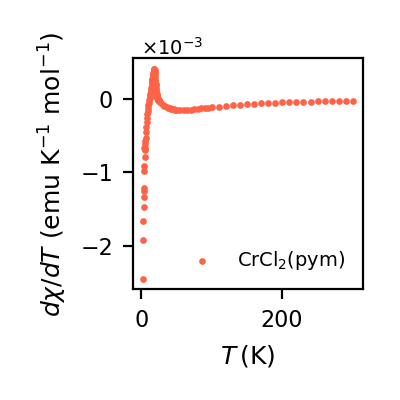

In [8]:
fig = plt.figure(21, figsize=(2,2))
cmap = plt.get_cmap('Set1')

T_range = np.arange(0.01,300,0.01)
plt.scatter(T[1:],(chi[1:]-chi[:-1])/(T[1:]-T[:-1])*1e3,color='tomato',label='CrCl$_2$(pym)', s=2)
plt.text(0, 0.6, '$\\times 10^{-3}$',fontsize=7)

plt.legend(shadow=False, fontsize=7,loc=4,frameon=False)
plt.xlabel('$T\\,$(K)',fontsize=9)
plt.ylabel('$d \\chi /dT$ (emu K$^{-1}$ mol$^{-1}$)',fontsize=9)
plt.tick_params(axis='both', labelsize=8)
plt.tight_layout()
#plt.xlim(5,35)
#plt.ylim(-0.2,0.5)
#plt.savefig('dchi_by_dT-Cr(pym)Cl$_2$_ZFC.pdf', transparent=True)
plt.show()

<IPython.core.display.Javascript object>


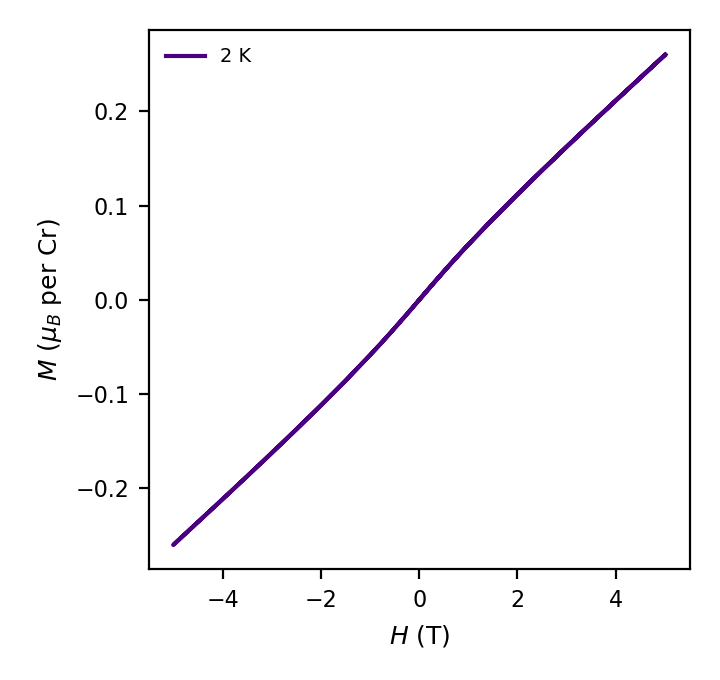

In [9]:
H2K,M2K,BMM2K = raw_datafile_2_MH("MPMS_CrCl2pym_MH.rso.dat",molar_mass,mass,dia)

fig = plt.figure(5, figsize=(3.6, 3.4)) #size in inches
ax1 = plt.subplot()
ax1.plot(H2K,BMM2K,color='indigo', label='2 K')

ax1.legend(frameon=False,fontsize=7,loc=2)
ax1.set_xlabel('$H$ (T)',fontsize=9)
ax1.set_ylabel('$M$ ($\\mu_B$ per Cr)',fontsize=9)
plt.yticks([-0.2,-0.1,0,0.1,0.2],fontsize=8)
plt.xticks([-4,-2,0,2,4],fontsize=8)
ax1.tick_params(axis='both', labelsize=8)
plt.tight_layout()
#ax1.set_xlim(-50,50)
#ax1.set_ylim(-2,2)

#plt.savefig('MH_CrpymCl2_sicogi.pdf',bbox_inches='tight', transparent=True)
plt.show()

<IPython.core.display.Javascript object>


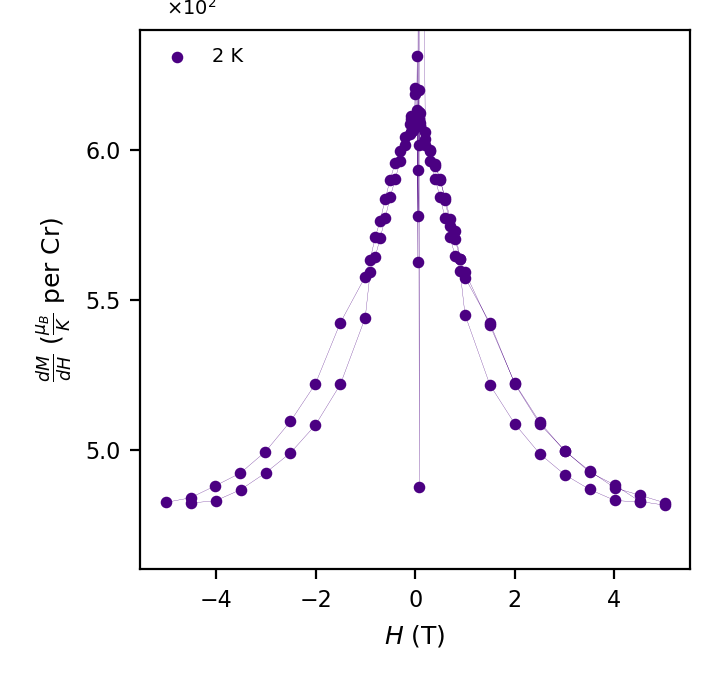

In [10]:
H2K,M2K,BMM2K = raw_datafile_2_MH("MPMS_CrCl2pym_MH.rso.dat",molar_mass,mass,dia)

fig = plt.figure(50, figsize=(3.6, 3.4)) #size in inches
ax1 = plt.subplot()

dH2K=(H2K[1:]-H2K[:-1])
x=dH2K
dH2K = ma.masked_array(dH2K, mask=np.where(H2K == 0))

dBMM2K=(BMM2K[1:]-BMM2K[:-1])
dBMM2K = ma.masked_array(dBMM2K, mask=np.where(H2K == 0))

dMdH = dBMM2K/dH2K
dMdH = ma.masked_array(dMdH, mask=np.logical_or(dMdH<0,dMdH>1))

plt.scatter(H2K[1:],dMdH*100,color='indigo', label='2 K',s=10)
plt.plot(H2K[1:],dMdH*100,color='indigo',linewidth=0.1)

ax1.legend(frameon=False,fontsize=7,loc=2)
ax1.set_xlabel('$H$ (T)',fontsize=9)
ax1.set_ylabel('$\\frac{dM}{dH}$ ($\\frac{\\mu_B}{K}$ per Cr)',fontsize=9)
plt.xticks([-4,-2,0,2,4],fontsize=8)
plt.yticks([5,5.5,6],fontsize=8)
ax1.tick_params(axis='both', labelsize=8)
ax1.text(-5, 6.45, '$\\times 10^2$',fontsize=7)
plt.tight_layout()
#ax1.set_xlim(-50,50)
ax1.set_ylim(4.6,6.4)

#plt.savefig('dMdH_CrpymCl2_sicogi.pdf',bbox_inches='tight', transparent=True)
plt.show()